In [1]:
using LinearAlgebra
using Jacobi
using Plots
using Test

# Orthogonal Polynomials on Genral Quadrilateral

# Construct, Display and Evaluating

All the concepts and algorithms developed for orthogonal polynomial in 1D can be extended to polynomial in 2 variables $(x,y)$.

Lets start with constructing a polynomial in 2D. Suppose we have 1D polynomial in $x$ and $y$ directions described by coefficients $p_x$ and $p_y$. We can construct a 2D polynomial using the tensor product 1D polynomial basis.

For example, consider $p_x = [1, 2, 3],\quad (p(x)=1 + 2x + 3x^2)$ and $p_y=[4,5], \quad (p(y)=4+5y)$, then
$$
P = px \otimes py = \begin{bmatrix}4 & 5\\8 & 10\\12 & 15 \end{bmatrix}, \quad P(x,y) = 4+8x+12x^2+5y+10xy+15x^2y
$$
You notice that we can also represent $P(x,y)$ as
$$
P(x,y) = y^0\Big( 4+8x+12x^2 \Big) + y^1\Big( 5+10x+15x^2 \Big) = x^0\Big(4 +5y \Big)+x^1\Big(8 +10y\Big)+x^2\Big(12 +15y\Big)
$$
which shows for $P$ of size $(n,m)$ column $j$ is a polynomial of form $y^{j-1} p_{n-1}(x)$ and row $i$ is $x^{i-1} q_{m-1}(y)$.

The following functions construct, display, and evaluate polynomial in 2D from $p_x, p_y$. Note that in polyval function we use Horner's rule in 1D since we can represnet column $j$ of $P_{n\times m}$ by $y^{j-1} p_{n-1}(x)$.

In [2]:
function poly2d(px, py)
    """
    Construct a 2D polynomial based on 1D basis in x and y directions.
    Input:
    px: polynomial in x direction
    py: polynomial in y direction
    Return:
    Matrix p, which is the coefficients of a 2D polynomial p(x,y)
    """
    px = reshape(px, :)
    py = reshape(py, :)
    # degree of poly in x
    n = length(px)
    # degree of poly in y
    m = length(py)
    # construct poly coefficients in 2D and store it in p
    p = zeros(n, m)
    for i=1:length(px)
        for j=1:length(py)
            p[i,j] = px[i] * py[j]
        end
    end
    
    return p
end

function polystring(p)
    """Construct a string representation of the polynomial p(x,y) in 2D
    p: polynomial coefficients in x and y directions created by poly2d function 
    """
    n,m = size(p)
    k = n * m
    pol = Array{String}(undef, k)
    kk = 1
    for j=1:m
        for i=1:n
            a = p[i,j] 
            pol[kk] = "$a x^$(i-1) y^$(j-1)"
            kk += 1 
        end
    end
            
    join((pol[i] for i=1:k), " + ")
end

function polydisp(name, p)
    """Display the polynomial with friendly math formatting.
    p: polynomial coefficients in x and y directions created by poly2d function
    """
    
    s = join(('$', "$name(x,y) = ", polystring(p), '$'))
    # If you download this notebook, you can uncomment the following
    # line to display rendered math.
    display("text/latex", s)
    # This feature is broken in Ed's "Saturn" so we'll just display
    # plain text.
    #display("text/plain", s)
end

function polyval2d(p, x, y)
    """Evaluate function described by coefficients p at point (x,y).
    Input:
    p: polynomial coefficients in 2D build from poly2D(px,py) function 
    Return:
    The value of p(x,y) at (x,y). Note (x,y) can be provided as a vector
    """
    # first we compute each column using Horner's rule
    # then multiply by y^(j-1), we can represent matrix P by
    # 1st col=y^0 * [f1_n(x)], 2nd col=y^1 * [f2_n(x)],... OR
    # 1st row=x^0 * [g1_m(y)], 2nd row=x^1 * [g2_m(y)],... 
    # we use the first one to evaluate poly in 2D
    n,m = size(p)
    g = zero.(x)
    for j = 1:m
        p1 = zeros(n)
        p1[:] = p[:,j]
        f = one.(x) * p1[end]
        for a in reverse(p1[1:end-1])
            f = a .+ x .* f
        end
        g += f .* y.^(j-1)
    end
    return g
end

polyval2d (generic function with 1 method)

In [3]:
p = poly2d([0 2],[3 4])
polydisp("f",p)

In [4]:
p1 = poly2d([1 2], [3 4])
@test polyval2d(p1, [1], [1]) == [21]
@test polyval2d(p1, [1;-1], [1;-1]) == [21;1]
p2 = poly2d([1 2 -3], [4 5])
@test polyval2d(p2, [1;-1], [1;-1]) == [0;4]

Test Passed

# Addition and subtraction
In the following we add/subtract $p(x,y)$ and $q(x,y)$ which they are created based on 1D basis $(p_x,p_y)$ and $(q_x,q_y)$ using poly2D function. lets assume the coefficients of 2D polynomial $p(x,y)$ and $q(x,y)$ are stored in matrices $\boldsymbol{P}_{n_1\times m_1}$ and $\boldsymbol{Q}_{n_2\times m_2}$, respectively. Then all we need is to add or subtract same entries of these two matrices and stored it in new matrix with size $(n,m)$ where $n=\text{max}(n_1,n_2), m = \text{max}(m_1,m_2)$

In [5]:
function polyaddsub1d(p, q, mode)
    """
    Addition/subtraction of two 1D polynomials p and q.
    (maybe we don't need this function)
    mode: "add" for addition "sub" for subtraction
    """
    p = reshape(p, :)
    q = reshape(q, :)
    n = max(length(p), length(q))
    r = zeros(n)
    r[1:length(p)] = p
    if mode == "add"
        r[1:length(q)] += q
    elseif mode == "sub"
        r[1:length(q)] -= q
    else
        error("mode must be add or sub")
    end
    reshape(r, 1, :)
    
    return r
end

function polyaddsub2d(p, q, mode)
    """
    Add/subtract two polynomials p and q in 2D.
    Input:
    p: Coefficients of 2D polynomial created by poly2D(px,py)
    q: Coefficients of 2D polynomial created by poly2D(qx,qy)
    mode: "add" for addition "sub" for subtraction
    Return:
    P: a matrix which is the coefficients of p(x,y) +/- q(x,y)
    """
    (n1,m1) = size(p)
    (n2,m2) = size(q)
    
    # scatter pp in matrix P1 of size(n,m)
    n = max(n1, n2)
    m = max(m1, m2)
    P1 = zeros(n,m)
    P1[1:n1,1:m1] = p
    # scatter qq in matrix P2 of size(n,m)
    P2 = zeros(n,m)
    P2[1:n2,1:m2] = q
    
    # add or subtract P1 and P2
    if mode == "add"
        P = P1 + P2
    elseif mode == "sub"
        P = P1 - P2
    else
        error("mode must be add or sub")
    end
    
    return P
end

polyaddsub2d (generic function with 1 method)

In [6]:
P1 = [4 5;14 18;-12 -15]
p = poly2d([0 2],[3 4])
q = poly2d([1 2 -3],[4 5])
@test polyaddsub2d(p,q,"add") == P1

Test Passed

# Multiplying Polynomials
Consider $p(x,y)$ and $q(x,y)$ given by the coefficients $\boldsymbol{P}_{n_1\times m_1}$ and $\boldsymbol{Q}_{n_2\times m_2}$. We know column $j$ of $\boldsymbol{P}$ represents $y^{j-1}f_{n_1-1}(x)$ and column $l$ of $\boldsymbol{Q}$ is $y^{l-1}g_{n_2-1}(x)$, so we can multiply these two columns using 1D multiplying polynomial function, then add those columns which they represent same degree of $y$. For example, lets consider $\boldsymbol{P}_{2\times 2}$ and $\boldsymbol{Q}_{3\times 2}$,
$$
p(x,y) = y^0 \,f_1(x) + y^1 \, g_1(x), \quad q(x,y) = y^0 \,h_2(x) + y^1 \, k_2(x)
$$
then,
$$
p(x,y) \, q(x,y) = y^0 \,f_1(x) \, h_2(x) + y^1 \, \Big( f_1(x)\,k_2(x) + g_1(x)\,h_2(x) \Big) + y^2 \,g_1(x)\,k_2(x)
$$

In [7]:
function polymul1d(p, q)
    """Multiply two polynomials in 1D, returinng a polynomial."""
    p = reshape(p, :)
    q = reshape(q, :)
    n = length(p) + length(q) - 1
    r = zeros(n)
    for (i, a) in enumerate(p)
        for (j, b) in enumerate(q)
            r[i+j-1] += a * b
        end
    end
    # return a row vector (for easier viewing)
    reshape(r, 1, :)
    
    return r
end


function polymul2d(p, q)
    """
    Multiply two polynomials p and q in 2D.
    Input:
    p: Coefficients of 2D polynomial created by poly2D(px,py)
    q: Coefficients of 2D polynomial created by poly2D(qx,qy)
    Return:
    P: a matrix which is the coefficients of p(x,y) * q(x,y)
    """
    (n1,m1) = size(p)
    (n2,m2) = size(q)

    k1 = n1+n2-1
    k2 = m1+m2-1
    P1 = zeros(m1,k1,k2)
    for i=1:m1
        p1 = zeros(n1)
        # get column i of p or y^(i-1)f_{n1-1}(x)
        p1 = p[:,i]
        for j=1:m2
            q1 = zeros(n2)
            q1 = q[:,j]
            # multiply column i of p to all columns of q
            r = polymul1d(p1, q1)
            P1[i,:,j+(i-1)] = r
        end
    end
    # add those columns with same degree of y
    P = zeros(k1,k2)
    for i=1:m1
       P[:,:] += P1[i,:,:]
    end

    return P
end

polymul2d (generic function with 1 method)

In [8]:
P1 = [12 31 20;48 124 80;12 31 20;-72 -186 -120]
p = poly2d([1 2],[3 4])
q = poly2d([1 2 -3],[4 5])
@test polymul2d(p, q) == P1
P2 = [0 0 0;24 62 40;48 124 80;-72 -186 -120]
p = poly2d([0 2],[3 4])
q = poly2d([1 2 -3],[4 5])
@test polymul2d(p, q) == P2

Test Passed

## Inner products of polynomials

We will use the $L^2$ inner product on general quadrilateral $E$
$$ \langle u, v \rangle = \int_{E} u(x,y) v(x,y) \mathrm{d} x \mathrm{d} y $$
restricted to the case where $u(x,y)$ and $v(x,y)$ are polynomials. 

In [9]:
function BilinearMap(coord_E, xhat, yhat)
    """ 
    This function maps [xhat,yhat] in Ehat=[-1,1]^2 
    to (x,y) in quadrilateral E.
    Input:
    ------
    coord_E: coordinates of quadrilateral E .
    coord_E is 4x2 array
    coord_E = [x1 y1;x2 y2;x3 y3;x4 y4] with vertices numbering
    3----4
    |    |
    1----2
    [xhat, yhat] in Ehat
    Output:
    ------
    x, y: mapped vector in E.
    DF_E: Jacobian matrix
    J_E: det(DF_E)
    """
    m = length(xhat)
    P = 0.25 * [(1 .- xhat).*(1 .- yhat) (1 .+ xhat).*(1 .- yhat) (1 .- xhat).*(1 .+ yhat) (1 .+ xhat).*(1 .+ yhat)]
    P_E = P * coord_E
    # x=F_E(xhat)
    X = P_E
    x = X[:, 1]
    y = X[:, 2]
    # gradient of P, 1st row = dP/dxhat, 2nd row=dP/dyhat
    # GradP_(2m x 4)
    GradP = 0.25 * [-(1 .- yhat) (1 .- yhat) -(1 .+ yhat) (1 .+ yhat);
                    -(1 .- xhat) -(1 .+ xhat) (1 .- xhat) (1 .+ xhat)]

    # JT= [[dx/dxhat, dy/dxhat],
    #      [dx/dyhat, dy/dyhat]] (2m x 2)
    JT = GradP * coord_E
    dxdxhat = JT[1:m,1]
    dydxhat = JT[1:m,2]
    dxdyhat = JT[m+1:2*m,1]
    dydyhat = JT[m+1:2*m,2]
    J_E = dxdxhat .* dydyhat .- dydxhat .* dxdyhat
    
    DF_E = [dxdxhat dxdyhat;dydxhat dydyhat]
    
    return x, y, DF_E, J_E
end

function GetQuadrature2d(Q)
    """
    create Gauss points and weights on [-1, 1]^2
    """
    # 1D quadrature on [-1, 1]
    q = zgj(Q, 0.0, 0.0)
    w = wgj(q, 0.0, 0.0)
    
    W2 = zeros(Q*Q)
    Qx = zeros(Q*Q)
    Qy = zeros(Q*Q)
    for i=1:Q
        for j=1:Q
            k = (i-1)*Q +j
            Qx[k] = q[j]
            Qy[k] = q[i]
            W2[k] = w[j]*w[i]
        end
    end
    return W2, Qx, Qy
end

function poly_inner_product2d(u, v, coord_E)
    """the L2 inner product of u(x,y) and v(x,y) on quadrilateral E with coord_E
    Both u and v are polynomials expressed as matrix in the usual way.
    """
    P = polymul2d(u, v)
    n,m = size(P)
    # max degrees of poly in x or y
    n = max(n,m)-1
    # No. quadrature points in 1D
    Q = Int(ceil((n+1)/2))
    # get weights and quadrature points on [-1,1]^2
    W2, Qx, Qy = GetQuadrature2d(Q)
    # get J_E to updates weights and quadrature points on quadrilateral E
    x, y, DF_E, J_E = BilinearMap(coord_E, Qx, Qy)
    # evaluvate u*v at quadrature pts on E
    R = polyval2d(P,x,y)
    # loop over quadrature
    inprod_uv = (J_E .* W2)' * R
    
    return inprod_uv 
end


function poly_norm2d(u, coord_E)
    """Compute the norm of the polynomial u(x,y) induced by poly_inner_product2d().
    """
    inprod_uu = poly_inner_product2d(u, u, coord_E)

    return sqrt(inprod_uu)
end

poly_norm2d (generic function with 1 method)

In [10]:
coord_E = [-1. -1.;1. -1.;-1. 1;1. 1.]
err = 1e-14
p = poly2d([0 2],[3 4])
q = poly2d([1 2],[0 4])
#exact value: int (p*q)dxdy = int(y[24x+48x^2] + y^2[32x+64x^2]) = 256/9
@test isapprox(poly_inner_product2d(p, q, coord_E), 256/9, atol=err)
p = poly2d([0 1],[0 0 1])
q = poly2d([0 1 1],[0 0 1])
#exact value: int (p*q)dxdy = int(y^4[x^2+x^3]) = 4/15
@test isapprox(poly_inner_product2d(p, q, coord_E), 4/15, atol=err)

Test Passed

In [11]:
function monomials(n)
    """Return a list of the first n monomials in order of increasing degree.
    We will think of this as a "tall" matrix indexed by its n columns.
    Each column contains a polynomial.
    For example for n = 3, we have 1, x, x^2
    """
    A = []
    for j in 1:n
        p = zeros(j)
        p[end] = 1
        push!(A, p)
    end
    return A
end


function monomials2d(n, m)
    """
    Input:
    n: number of basis in x direction in order of increasing degree
    m: number of basis in y direction in order of increasing degree
    Return:
    A list which contains matrices for 2D polynomial
    """
    A = monomials(n)
    B = monomials(m)
    P = []
    for j = 1:m
        q = copy(B[j])
        for i = 1:n
            p = copy(A[i])
            pq = poly2d(p,q)
            push!(P, pq)
        end
    end
    return P
end

monomials2d (generic function with 1 method)

In [12]:
function poly_qr2d(n,m, coord_E)
    """
    n: number of poly basis in x direction
    m: number of poly basis in y direction
    coord_E: coordinates of quadrilateral E
    returns Q, R which Q is a list of size n*m of matrices
    contains orthogonal poly on E
    """
    
    A = monomials2d(n,m)
    Q = []
    R = zeros(n*m, n*m)
    for j = 1:m
        for i = 1:n
            k = i + n*(j-1) # kth column of A
            v = copy(A[k])
            for l = 1:k-1
                r = poly_inner_product2d(Q[l],v, coord_E)
                R[l, k] = r
                v = polyaddsub2d(v,Q[l]*r,"sub")
            end
            r = poly_norm2d(v, coord_E)
            R[k,k] = r
            push!(Q,v/r)
        end
    end
            
    return Q, R
end

function poly_QtQ(Q, coord_E)
    """Compute Q.T Q where Q is a matrix of polynomials
    expressed as a list of matrices. The result is an ordinary
    square matrix.
    """
    n = length(Q)
    A = zeros(n, n)
    for i in 1:n
        for j in 1:n
            A[i,j] = poly_inner_product2d(Q[i], Q[j], coord_E)
        end
    end
    A
end

poly_QtQ (generic function with 1 method)

# Test Polynomial on $\hat{E} = [-1,1]^2$

In [13]:
coord_E = [-1. -1.;1. -1.;-1. 1;1. 1.]
Q, R = poly_qr2d(3, 3, coord_E)
QtQ = poly_QtQ(Q, coord_E)
@show norm(QtQ - I)

norm(QtQ - I) = 2.560618590774332e-15


2.560618590774332e-15

In [14]:
polydisp("f",Q[6])

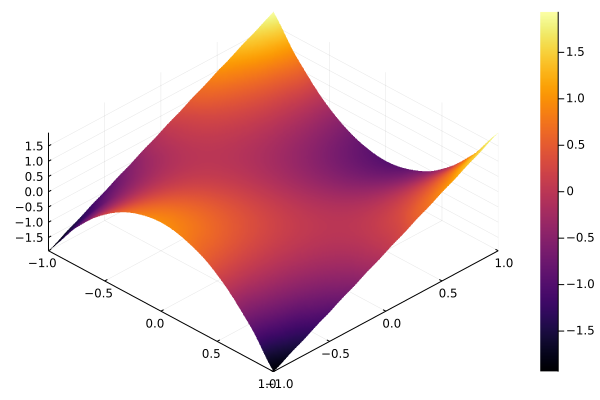

In [15]:
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
n = 10
x, y = meshgrid(LinRange(-1,1,n), LinRange(-1,1,n))
p = polyval2d(Q[6],x,y)
plot(x, y, p, st = :surface, camera = (45,70))

# Test on General Quad E

In [16]:
coord_E = [0. 0.;2. 0.;0. 1;2. 1.]
Q, R = poly_qr2d(3, 3, coord_E)
QtQ = poly_QtQ(Q, coord_E)
@show norm(QtQ - I)

norm(QtQ - I) = 7.202928815612741e-13


7.202928815612741e-13

In [17]:
polydisp("f",Q[6])

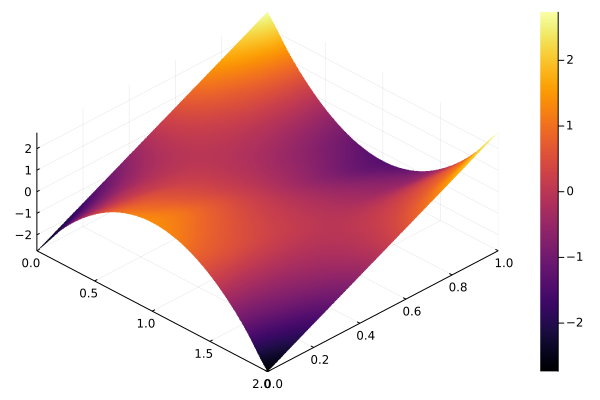

In [18]:
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)))
n = 10
x, y = meshgrid(LinRange(0,2,n), LinRange(0,1,n))
p = polyval2d(Q[6],x,y)
plot(x, y, p, st = :surface, camera = (45,70))